In [158]:
!pip install unidecode

In [159]:
import torch
import torch.nn as nn

seed = 1
torch.manual_seed(seed)

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
import unidecode

nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Read Dataset

In [160]:
dataset_path = '/kaggle/input/aiomodule6financial-news-sentiment-analysis/dataset/all-data.csv'
headers = ['sentiment', 'content']
df = pd.read_csv(
    dataset_path,
    names=headers,
    encoding='ISO-8859-1'
)
df.head()

,sentiment,content
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [161]:
classes = {
    class_name: idx for idx, class_name in enumerate(df['sentiment'].unique().tolist())
}
df['sentiment'] = df['sentiment'].apply(lambda x: classes[x])
df.head()

,sentiment,content
0,0,"According to Gran , the company has no plans t..."
1,0,Technopolis plans to develop in stages an area...
2,1,The international electronic industry company ...
3,2,With the new production plant the company woul...
4,2,According to the company 's updated strategy f...


### Text Normalisation

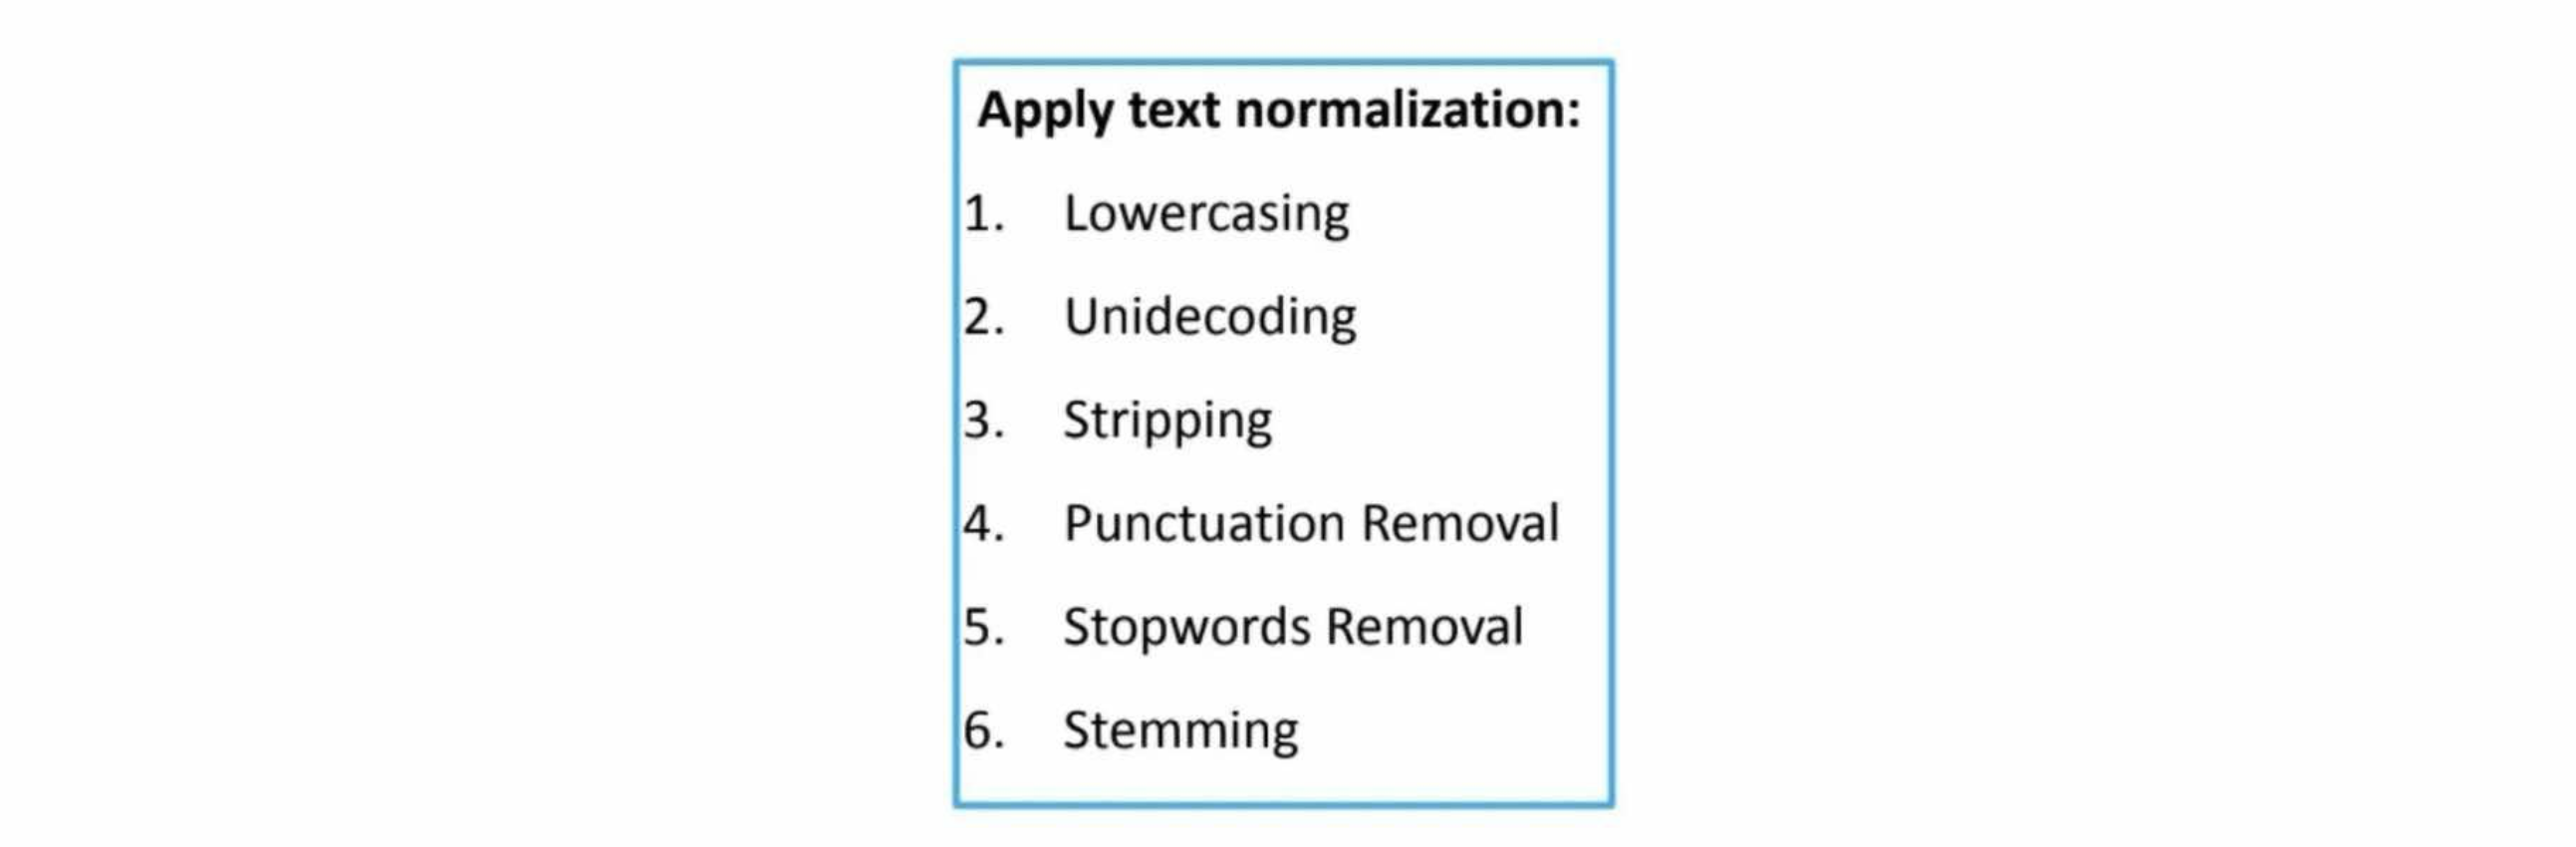

In [162]:
text = df['content'][1]
text

'Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications , the statement said .'

In [163]:
print(unidecode.unidecode(text))

Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications , the statement said .


In [164]:
print(re.sub(r'[^\w\s]', '', text))

Technopolis plans to develop in stages an area of no less than 100000 square meters in order to host companies working in computer technologies and telecommunications  the statement said 


In [165]:
english_stop_words = stopwords.words('english')
stemmer = PorterStemmer()

def text_normalize(text):
    text = text.lower() 
    text = unidecode.unidecode(text)
    text = text.strip()
    text = re.sub(r'[^\w\s]', '', text) # punctuation removal
    text = ' '.join([word for word in text.split(' ') if word not in english_stop_words])
    text = ' '.join([stemmer.stem(word) for word in text.split(' ')])
    
    return text

### Build Transform Function

In [166]:
vocab = []
for sentence in df['content'].tolist():
    # Tokenazation
    tokens = sentence.split()
    for token in tokens:
        if token not in vocab:
            vocab.append(token)

vocab.append('UNK')
vocab.append('PAD')

word_to_idx = {word: idx for idx, word in enumerate(vocab)}
vocab_size = len(vocab)

def transform(text, word_to_idx, max_seq_len):
    tokens = []
    for w in text.split():
        try:
            w_ids = word_to_idx[w]
        except:
            w_ids = word_to_idx['UNK']
        tokens.append(w_ids)

    if len(tokens) < max_seq_len:
        tokens += [word_to_idx['PAD']] * (max_seq_len - len(tokens)) 
    elif len(tokens) > max_seq_len:
        tokens = tokens[:max_seq_len]

    return tokens

### Split train, test

In [167]:
df['content'].tolist()[:5]

['According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .',
 'Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications , the statement said .',
 'The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers , the daily Postimees reported .',
 'With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profitability .',
 "According to the company 's updated strategy for the years 2009-2012 , Basware targets a long-term net sales growth in the range of 20 % -40 % with an operating profit margin of 10 % -20 % of net sales ."]

In [168]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

texts = df['content'].tolist()
labels = df['sentiment'].tolist()

X_train, X_val, y_train, y_val = train_test_split(
    texts, labels,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=seed,
    shuffle=is_shuffle
)

In [169]:
class FinancialNews(Dataset):
    def __init__(self, X, y, word_to_idx, max_seq_len, transform=None):
        self.texts = X
        self.labels = y
        self.word_to_idx = word_to_idx
        self.max_seq_len = max_seq_len
        self.transform = transform

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        if self.transform:
            text = self.transform(text, self.word_to_idx, self.max_seq_len)

        text = torch.tensor(text)
        return text, label

In [170]:
max_seq_len = 32

train_dataset = FinancialNews(
    X_train, y_train,
    word_to_idx=word_to_idx,
    max_seq_len=max_seq_len,
    transform=transform
)

val_dataset = FinancialNews(
    X_val, y_val,
    word_to_idx=word_to_idx,
    max_seq_len=max_seq_len,
    transform=transform
)

test_dataset = FinancialNews(
    X_test, y_test,
    word_to_idx=word_to_idx,
    max_seq_len=max_seq_len,
    transform=transform
)

In [171]:
# Check 0-th sample and dataset length
text0, label0 = train_dataset[0]
print(f"Train 0-th sample - text shape: {text0.shape}, label: {label0}")
print(f"Train dataset length: {len(train_dataset)}")

text0_val, label0_val = val_dataset[0]
print(f"Val 0-th sample - text shape: {text0_val.shape}, label: {label0_val}")
print(f"Val dataset length: {len(val_dataset)}")

text0_test, label0_test = test_dataset[0]
print(f"Test 0-th sample - text shape: {text0_test.shape}, label: {label0_test}")
print(f"Test dataset length: {len(test_dataset)}")


Train 0-th sample - text shape: torch.Size([32]), label: 1
Train dataset length: 3391
Val 0-th sample - text shape: torch.Size([32]), label: 2
Val dataset length: 970
Test 0-th sample - text shape: torch.Size([32]), label: 1
Test dataset length: 485


In [172]:
train_batch_size = 128
test_batch_size = 8

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)


In [173]:
for batch in train_loader:
    text, label = batch
    print(f"Train batch - text shape: {text.shape}, label shape: {label.shape}")
    break  # only check the first batch

for batch in val_loader:
    text, label = batch
    print(f"Validation batch - text shape: {text.shape}, label shape: {label.shape}")
    break

for batch in test_loader:
    text, label = batch
    print(f"Test batch - text shape: {text.shape}, label shape: {label.shape}")
    break

Train batch - text shape: torch.Size([128, 32]), label shape: torch.Size([128])
Validation batch - text shape: torch.Size([8, 32]), label shape: torch.Size([8])
Test batch - text shape: torch.Size([8, 32]), label shape: torch.Size([8])


### Model Construction

Model 1

In [174]:
class SentimentClassifier(nn.Module):
    def __init__(
        self, vocab_size, embedding_dim, rnn_cell,
        hidden_size, n_layers, n_classes,
        dropout_prob, use_global_pooling = False
    ):
        super().__init__()

        self.use_global_pooling = use_global_pooling
        self.rnn_cell = rnn_cell

        self.averagepool = nn.AdaptiveAvgPool1d(1)
        
        self.embedding = nn.Embedding(
            vocab_size, embedding_dim
        )
        
        if self.rnn_cell == True:
            self.cell = nn.RNN(
                embedding_dim,
                hidden_size,
                n_layers,
                batch_first=True
            )
        else:
            self.cell = nn.LSTM(
                embedding_dim,
                hidden_size,
                n_layers,
                batch_first=True
            )
               
        self.norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc1 = nn.Linear(hidden_size, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, n_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = self.dropout(x)

        if self.rnn_cell == True:
            x, hn = self.cell(x)
        else:
            x, (hn, cn) = self.cell(x)
            
        if not self.use_global_pooling:  
            x = x[:, -1, :]
            x = self.norm(x)
            x = self.fc1(x)
            x = self.relu(x)
            x = self.fc2(x)
        else:
            x = x[:, :, :] # (B, L, D)
            x = self.norm(x)
            x = x.transpose(1, 2) # (B, D, L)
            x = self.averagepool(x) # (B, D, 1)
            x = x.squeeze(-1) # (B, D)
            x = self.fc1(x)
            x = self.relu(x)
            x = self.fc2(x)

        return x

In [175]:
n_classes = len(list(classes.keys()))
embedding_dim = 64
hidden_size = 64
n_layers = 2
dropout_prob = 0.2
use_global_pooling = False
rnn_cell = True

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = SentimentClassifier(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_size=hidden_size,
    rnn_cell = rnn_cell,
    n_layers=n_layers,
    n_classes=n_classes,
    dropout_prob=dropout_prob,
    use_global_pooling = use_global_pooling
)

In [176]:
from torchinfo import summary
summary(model, input_size=(32,100), dtypes=[torch.int64], device="cuda")

Layer (type:depth-idx)                   Output Shape              Param #
SentimentClassifier                      [32, 3]                   --
├─Embedding: 1-1                         [32, 100, 64]             830,272
├─Dropout: 1-2                           [32, 100, 64]             --
├─RNN: 1-3                               [32, 100, 64]             16,640
├─LayerNorm: 1-4                         [32, 64]                  128
├─Linear: 1-5                            [32, 16]                  1,040
├─ReLU: 1-6                              [32, 16]                  --
├─Linear: 1-7                            [32, 3]                   51
Total params: 848,131
Trainable params: 848,131
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 79.86
Input size (MB): 0.03
Forward/backward pass size (MB): 3.30
Params size (MB): 3.39
Estimated Total Size (MB): 6.72

In [177]:
for batch in train_loader:
    text, label = batch
    print(model.to('cpu')(text).shape)
    break

torch.Size([128, 3])


In [178]:
from typing import Literal, Optional
from torch.optim.lr_scheduler import StepLR, ExponentialLR
class training_model:
    def __init__(self, model, train_loader, val_loader, test_loader, optimizer, criterion, scheduler: callable = None, metrics: dict[str, callable] = {"Accuracy": (accuracy_score, {})}, refit: str = "Accuracy"):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.optimizer = optimizer
        self.criterion = criterion
        self.metrics = metrics
        self.refit = refit
        self.best_model_state = None
        self.scheduler = scheduler

    # Define train function
    def train_session(self):
        train_loss = 0
        total_samples = 0
        
        y_train_label_pred = []
        y_train_label_true = []

        metric_dict_train = {}

        # training session
        self.model.train()
        for X_train, y_train in self.train_loader:
            # X_train: (batch_size, in_channels, height, width)
            # y_train: (batch_size)

            y_train = y_train.to(device)
            X_train = X_train.to(device)
            
            self.optimizer.zero_grad() # reset optimizer gradients

            # forward pass
            output = self.model(X_train) # output: (batch_size, num_classes)

            # calculate loss
            loss = self.criterion(output, y_train)
            train_loss += loss.item() * len(y_train)
            total_samples += len(y_train)

            # Predictions
            y_train_label_true.extend(y_train.tolist())
            y_train_label_pred.extend(torch.argmax(output, dim=1).tolist())

            # calculate gradients
            loss.backward()

            # update weights
            self.optimizer.step()
        
        train_loss /= total_samples

        for metric_name, (metric_func, kwargs) in self.metrics.items():
            metric = metric_func(y_train_label_true, y_train_label_pred, **kwargs)
            metric_dict_train[metric_name] = metric

        return train_loss, metric_dict_train
    
    # Define validation (testing) function
    def eval_session(self, mode: Literal['Eval', 'Test'] = 'Eval'):
        # validation session
        self.model.eval()
        with torch.no_grad():
            if mode == "Eval":
                val_loss = 0
                total_samples = 0

                y_val_label_pred = []
                y_val_label_true = []

                metric_dict_val = {}
                for X_val, y_val in self.val_loader:
                    # X_val: (batch_size, in_channels, height, width)
                    # y_val: (batch_size)
    
                    y_val = y_val.to(device)
                    X_val = X_val.to(device)
                    
                    # forward pass
                    output = self.model(X_val) # output: (batch_size, num_classes)
    
                    # calculate loss
                    loss = self.criterion(output, y_val)
                    val_loss += loss.item() * len(y_val)
                    total_samples += len(y_val)
    
                    # Predictions
                    y_val_label_true.extend(y_val.tolist())
                    y_val_label_pred.extend(torch.argmax(output, dim=1).tolist())
            
                val_loss /= total_samples
        
                for metric_name, (metric_func, kwargs) in self.metrics.items():
                    metric = metric_func(y_val_label_true, y_val_label_pred, **kwargs)
                    metric_dict_val[metric_name] = metric
        
                return val_loss, metric_dict_val
            elif mode == "Test":
                test_loss = 0
                total_samples = 0

                y_test_label_pred = []
                y_test_label_true = []

                metric_dict_test = {}
                for X_test, y_test in self.test_loader:
                    # X_test: (batch_size, in_channels, height, width)
                    # y_test: (batch_size)
    
                    y_test = y_test.to(device)
                    X_test = X_test.to(device)
                    
                    # forward pass
                    output = self.model(X_test) # output: (batch_size, num_classes)
    
                    # calculate loss
                    loss = self.criterion(output, y_test)
                    test_loss += loss.item() * len(y_test)
                    total_samples += len(y_test)
    
                    # Predictions
                    y_test_label_true.extend(y_test.tolist())
                    y_test_label_pred.extend(torch.argmax(output, dim=1).tolist())
            
                test_loss /= total_samples
        
                for metric_name, (metric_func, kwargs) in self.metrics.items():
                    metric = metric_func(y_test_label_true, y_test_label_pred, **kwargs)
                    metric_dict_test[metric_name] = metric
        
                return test_loss, metric_dict_test
                

    def train(self, epochs):
        train_lossess = []
        val_lossess = []

        metric_dict_train_collect = {}
        metric_dict_val_collect = {}

        best_score = 0.0

        for epoch in range(epochs):
            score_collect_val = ''
            score_collect_train = ''
            
            train_loss, metric_dict_train = self.train_session()
            val_loss, metric_dict_val = self.eval_session()

            # save loss and accuracy
            train_lossess.append(train_loss)
            val_lossess.append(val_loss)

            for metric_name, metric_value in metric_dict_train.items():
                if metric_name not in metric_dict_train_collect:
                    metric_dict_train_collect[metric_name] = []
                metric_dict_train_collect[metric_name].append(metric_value)

                score_collect_train += f' - {metric_name}: {metric_value:.4f}'

            for metric_name, metric_value in metric_dict_val.items():
                if metric_name not in metric_dict_val_collect:
                    metric_dict_val_collect[metric_name] = []
                metric_dict_val_collect[metric_name].append(metric_value)

                score_collect_val += f' - {metric_name}: {metric_value:.4f}'

                if metric_name == self.refit:
                    # Save best model based on validation F1 score
                    if metric_value > best_score:
                        best_score = metric_value
                        self.best_model_state = self.model.state_dict()
                        print("=====================")
                        print(f"Epoch {epoch+1}: New best {metric_name} on val = {best_score:.4f}, saving model...") 
                        print("=====================")

            print("=====================")
            print(f"Epoch {epoch + 1} completed")
            print(f"Train Loss: {train_loss:.4f}" + score_collect_train)
            print(f"Val Loss: {val_loss:.4f}" + score_collect_val)
            print("=====================")
     
            if self.scheduler is not None:
                self.scheduler.step()
        return train_lossess, val_lossess, metric_dict_train_collect, metric_dict_val_collect, self.best_model_state

    def test(self):
        best_model_state = self.best_model_state
        self.model.load_state_dict(best_model_state)

        score_collect = ''
        test_loss, metric_dict_test = self.eval_session(mode = "Test")
        
        for metric_name, metric_value in metric_dict_test.items():
            score_collect += f'- {metric_name}: {metric_value}'

        print(f'Test session - Test Loss: {test_loss} ' + score_collect)

In [185]:
n_classes = len(list(classes.keys()))
embedding_dim = 64
hidden_size = 64
n_layers = 2
dropout_prob = 0.2
use_global_pooling = True
rnn_cell = True #True for RNN, False LSTM

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = SentimentClassifier(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_size=hidden_size,
    rnn_cell = rnn_cell,
    n_layers=n_layers,
    n_classes=n_classes,
    dropout_prob=dropout_prob,
    use_global_pooling = use_global_pooling
).to(device)

epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

In [186]:
from sklearn.metrics import f1_score
training = training_model(
    model = model,
    train_loader = train_loader,
    val_loader = val_loader,
    test_loader = test_loader,
    optimizer = optimizer,
    # scheduler = scheduler,
    criterion = criterion,
    metrics = {"F1 Score": (f1_score, {"average": "macro"})},
    refit = "F1 Score"
)

train_lossess, val_lossess, metric_dict_train_collect, metric_dict_val_collect, best_model_state = training.train(epochs)

Epoch 1: New best F1 Score on val = 0.2468, saving model...
Epoch 1 completed
Train Loss: 1.0144 - F1 Score: 0.3116
Val Loss: 0.9372 - F1 Score: 0.2468
Epoch 2 completed
Train Loss: 0.9224 - F1 Score: 0.2479
Val Loss: 0.9258 - F1 Score: 0.2468
Epoch 3 completed
Train Loss: 0.9115 - F1 Score: 0.2479
Val Loss: 0.9126 - F1 Score: 0.2468
Epoch 4: New best F1 Score on val = 0.2563, saving model...
Epoch 4 completed
Train Loss: 0.8987 - F1 Score: 0.2534
Val Loss: 0.8973 - F1 Score: 0.2563
Epoch 5: New best F1 Score on val = 0.2904, saving model...
Epoch 5 completed
Train Loss: 0.8773 - F1 Score: 0.2916
Val Loss: 0.8792 - F1 Score: 0.2904
Epoch 6: New best F1 Score on val = 0.3245, saving model...
Epoch 6 completed
Train Loss: 0.8570 - F1 Score: 0.3376
Val Loss: 0.8709 - F1 Score: 0.3245
Epoch 7: New best F1 Score on val = 0.3752, saving model...
Epoch 7 completed
Train Loss: 0.8466 - F1 Score: 0.3488
Val Loss: 0.8669 - F1 Score: 0.3752
Epoch 8 completed
Train Loss: 0.8398 - F1 Score: 0.3661


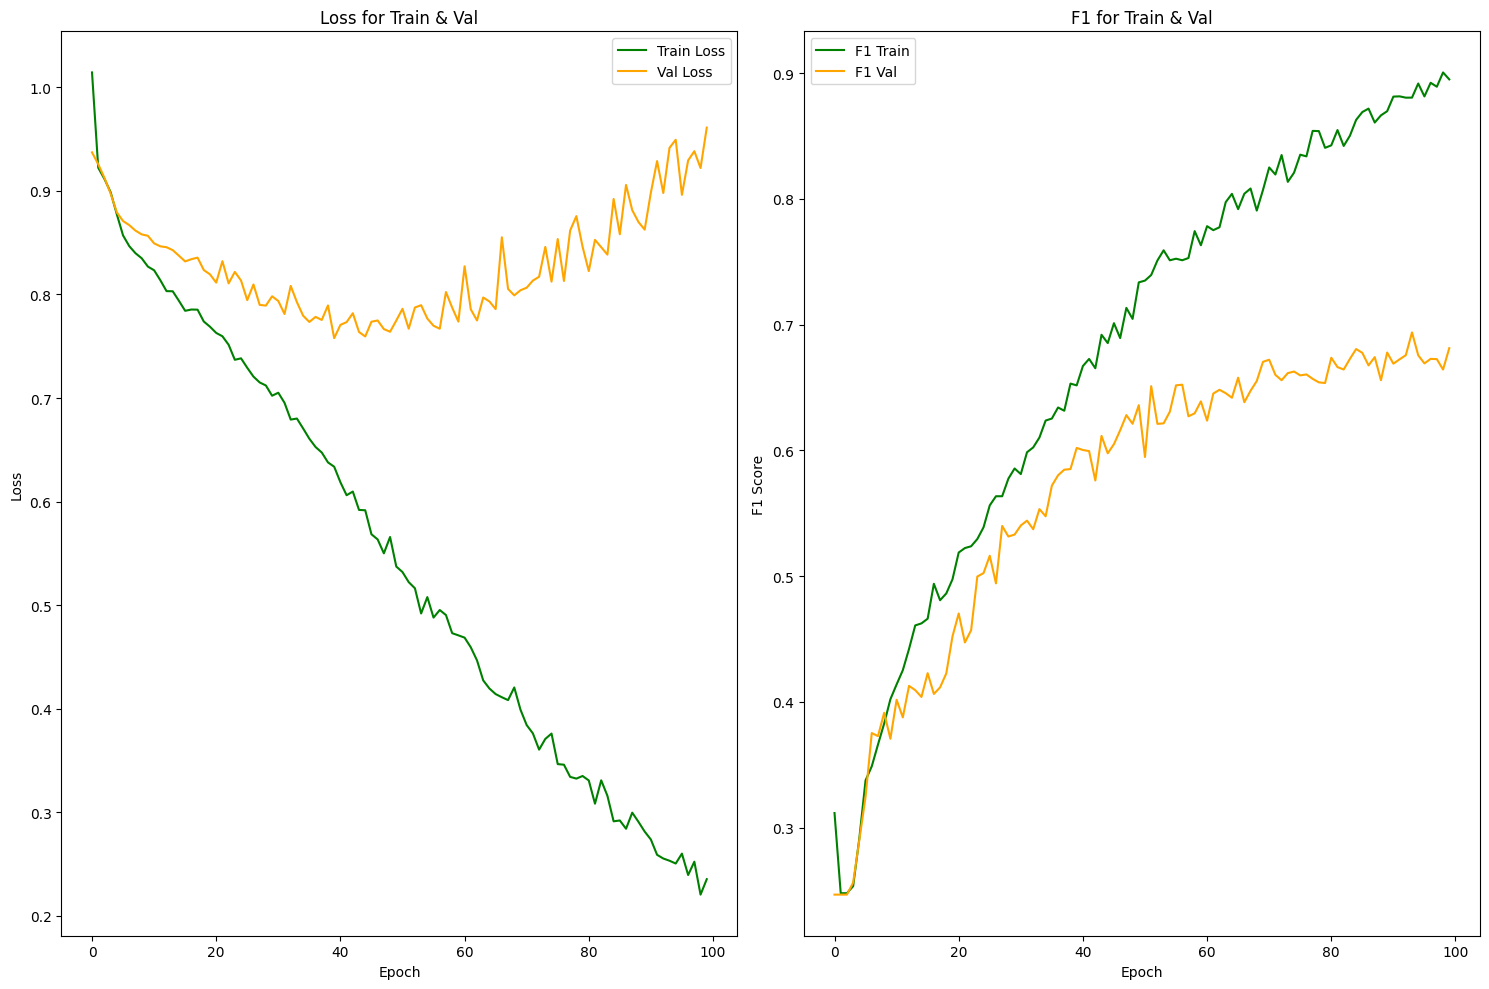

In [187]:
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].plot(train_lossess, color='green', label = 'Train Loss')
ax[0].plot(val_lossess, color='orange', label = 'Val Loss')
ax[0].set(xlabel='Epoch', ylabel='Loss')
ax[0].set_title('Loss for Train & Val')
ax[0].legend()

ax[1].plot(metric_dict_train_collect['F1 Score'], color='green', label = 'F1 Train')
ax[1].plot(metric_dict_val_collect['F1 Score'], color='orange', label = 'F1 Val')
ax[1].set(xlabel='Epoch', ylabel='F1 Score')
ax[1].set_title('F1 for Train & Val')
ax[1].legend()

plt.tight_layout()

plt.show()